# DeepShake Multi-step Time Series Forecasting

This notebook is a template for doing time series forecasting on the Ridgecrest dataset

In [1]:
import os
import sys
import py3nvml
sys.path.append("./networks/.")
sys.path.append("../utils/.")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(10)

import py3nvml

from utils import *
from lstm import *

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.backend import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.preprocessing import OneHotEncoder

In [3]:
print(sys.executable)
!which python

/home/ad9697/anaconda3/envs/tf_gpu/bin/python
/home/ad9697/anaconda3/envs/tf_gpu/bin/python


In [4]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# # os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

# # print(py3nvml.grab_gpus(1))

# from tensorflow.python.client import device_lib
# print (device_lib.list_local_devices())

In [5]:
!nvidia-smi
py3nvml.grab_gpus(1)


Sun Jun 28 20:40:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   38C    P0    37W / 250W |   8255MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   38C    P0    37W / 250W |  15961MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

/home/ad9697/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/py3nvml/utils.py:151: RuntimeWarning: Could not find enough GPUs for your job
  warnings.warn("Could not find enough GPUs for your job", RuntimeWarning)
GPU 3:	Used Mem: 1998.3125MB	Total Mem: 16160.5MB


0

## The Ridgecrest Dataset and parsed data
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [6]:
num_stations = 15
num_classes = 6

In [7]:
data_path = "../data/class_mmi"

x_train_multi = np.load(os.path.join(data_path, "X_train_unnorm.npy"))
x_val_multi = np.load(os.path.join(data_path, "X_val_unnorm.npy"))

y_train = np.load(os.path.join(data_path, "y_train.npy"))
y_val = np.load(os.path.join(data_path, "y_val.npy"))





In [8]:
y_train.shape, y_val.shape

((1998010, 15), (499520, 15))

In [9]:
# from sklearn.preprocessing import OneHotEncoder
# # creating one hot encoder object 
onehotencoder = OneHotEncoder()

y_train_OH = onehotencoder.fit_transform(y_train.reshape((-1, 1))).\
reshape((-1, num_classes*num_stations)).toarray()
y_val_OH = onehotencoder.fit_transform(y_val.reshape((-1, 1))).\
reshape((-1, num_classes*num_stations)).toarray()

In [10]:
np.save(os.path.join("y_val_OH.npy"), y_val_OH)

[14985075 14861315   112700     9240     1680      140]


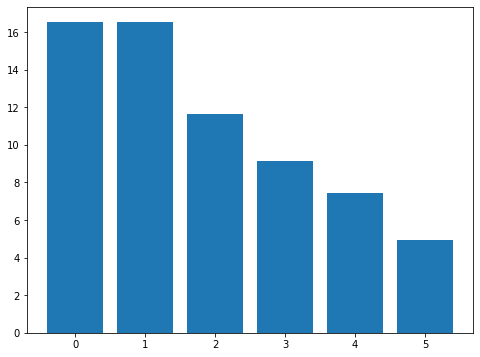

[3746400 3718400   25515    1645     595     245]


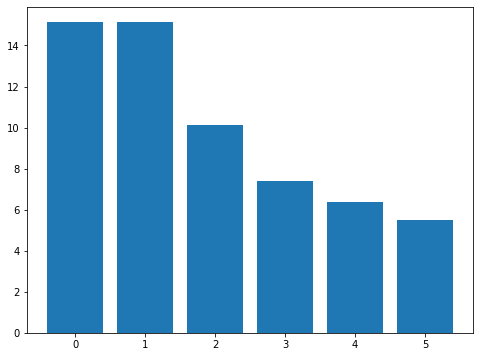

In [11]:
## Class prevalence
unique, counts = np.unique(y_train, return_counts=True)
print(counts)
plt.bar(unique, np.log(counts))
plt.show()

unique, counts = np.unique(y_val, return_counts=True)
print(counts)
plt.bar(unique, np.log(counts))
plt.show()

In [12]:
# X_scaler = preprocessing.StandardScaler().fit(x_train_multi)
# # mean_scaler = preprocessing.StandardScaler().fit(train_mean)
# # std_scaler = preprocessing.StandardScaler().fit(train_std)

# x_train_multi = X_scaler.transform(x_train_multi)
# # mean_scaled_train = mean_scaler.transform(train_mean)
# # std_scaled_train = std_scaler.transform(train_std)

# x_val_multi = X_scaler.transform(x_val_multi)
# # mean_scaled_val = mean_scaler.transform(val_mean)
# # std_scaled_val = std_scaler.transform(val_std)

In [13]:
import json
config_path = os.path.join(data_path, "config.json")
with open(config_path) as json_file:
    config = json.load(json_file)
    
_, past_history, STEP, future_target= list(config.values())


FileNotFoundError: [Errno 2] No such file or directory: '../data/class_mmi/config.json'

### Model with unnormalized log(acc)

In [36]:
# from tf.keras.backend import sparse_categorical_crossentropy
# from tf.keras.backend import categorical_crossentropy
# from tf.keras.metrics import categorical_accuracy

def get_multipred_crossentropy_loss_fn(predictions = 15, classes = 6):
    '''
    Returns a loss which expects a predictions * classes vector, reshapes, and sums up the individual categorical crossentropies
    '''
    def loss(y_true, y_pred):
        total_loss = 0
        for i in range(0, classes*predictions, classes):
            total_loss += categorical_crossentropy(y_true[i:i + classes], y_pred[i : i+classes])
            
        return total_loss
    
    return loss

def multipred_acc(y_true, y_pred):
    '''
    Returns an acc which expects a predictions * classes vector, reshapes
    '''
    avg_acc = 0
    for i in range(0, num_classes*num_stations, num_classes):
        avg_acc += categorical_accuracy(y_true[i:i + num_classes], y_pred[i : i+num_classes])
        
    avg_acc = avg_acc / num_stations
    return avg_acc

# def get_multipred_softmax_fn(predictions = 15, classes = 6):
#     '''
#     Expects a predictions * classes vector, reshapes to a 2d (predictions, classes), takes row-wise softmax, and flattens
#     '''
def multipred_softmax(x):
    output = K.reshape(K.softmax(K.reshape(x, (-1, num_stations, num_classes)), axis = -1), (-1, num_classes*num_stations))
    return output
    
#     return multipred_softmax

# def get_multipred_crossentropy_loss_fn(predictions = 15, classes = 6):
#     '''
#     Returns a loss which expects a predictions * classes vector, reshapes, and sums up the individual categorical crossentropies
#     '''
#     def loss(y_true, y_pred):
#         print(y_true.shape, y_pred.shape)
#         total_loss = 0
#         for i in range(0, classes*predictions, classes):
#             total_loss += sparse_categorical_crossentropy(y_true[int(i // classes)], y_pred[i : i+classes])
#         return total_loss
    
#     return loss

def model_v1():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128,
                                return_sequences=True,
                                input_shape=x_train_multi.shape[-2:]))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
    model.add(tf.keras.layers.LSTM(64, activation='relu'))
    model.add(tf.keras.layers.Dense(num_stations*num_classes, activation=Activation(multipred_softmax, name='custom_softmax')))

    # model.load_weights(model_path)

    model.compile(optimizer='nadam', loss=get_multipred_crossentropy_loss_fn(), metrics=[multipred_acc])
    model.summary()
    return model

def model_v2():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128,
                                return_sequences=True,
                                input_shape=x_train_multi.shape[-2:]))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_stations*num_classes*4, activation='relu'))   
    model.add(tf.keras.layers.Dense(num_stations*num_classes, activation=Activation(multipred_softmax, name='custom_softmax')))

    # model.load_weights(model_path)

    model.compile(optimizer='nadam', loss=get_multipred_crossentropy_loss_fn(), metrics=[multipred_acc])
    model.summary()
    return model

model = model_v2()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 15, 128)           73728     
_________________________________________________________________
lstm_22 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_23 (LSTM)               (None, 15, 64)            33024     
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 360)               345960    
_________________________________________________________________
dense_7 (Dense)              (None, 90)                32490     
Total params: 534,610
Trainable params: 534,610
Non-trainable params: 0
________________________________________________

In [37]:
# import numpy as np
# from tensorflow.keras.backend import variable

# y_true = np.zeros((15, 6))
# y_pred = y_true.copy()
# y_true[:7, 1] = 1
# y_true[7:, 2] = 1
# y_pred[:, 1] = 1
# print(y_pred, y_true)
# y_pred = variable(y_pred.flatten())
# y_true = variable(y_true.flatten())

# multipred_acc(y_pred, y_true)

In [38]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = .01
BATCH_SIZE=2048
save_path = "./trained_models_acc/mmi_classification"
if not os.path.exists(save_path):
    os.makedirs(save_path)
# cur_file = "LSTM3_10steps_dropzero"
cur_file = 'classifier_v2'
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_multipred_acc',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_multipred_acc',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_multipred_acc', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='auto')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Let's see how the model predicts before it trains.

In [39]:
# test_preds_tensor = variable(test_preds)
# y_val_OH_tensor = variable(y_val_OH)

In [40]:
# test_preds = model.predict(x_val_multi, batch_size = BATCH_SIZE)
# K.mean([multipred_acc(variable(test_preds[i]), variable(y_val_OH[i])) for i in range(len(y_val_OH))])

In [41]:
EPOCHS = 50
model_history = model.fit(x_train_multi, 
                          y_train_OH, 
                          epochs=EPOCHS,
                          validation_data=(x_val_multi, y_val_OH),
                          batch_size = BATCH_SIZE, 
                          callbacks=callback_list,
                          shuffle=True)

Train on 1998010 samples, validate on 499520 samples
Epoch 1/50
1996800/1998010 [============================>.] - ETA: 0s - loss: 742.4946 - multipred_acc: 0.0401
Epoch 00001: val_multipred_acc improved from -inf to 0.00751, saving model to ./trained_models_acc/mmi_classification/classifier_v2.h5
1998010/1998010 [==============================] - 395s 197us/sample - loss: 742.4925 - multipred_acc: 0.0400 - val_loss: 769.1596 - val_multipred_acc: 0.0075
Epoch 2/50
1996800/1998010 [============================>.] - ETA: 0s - loss: 689.8465 - multipred_acc: 0.0396
Epoch 00002: val_multipred_acc improved from 0.00751 to 0.02218, saving model to ./trained_models_acc/mmi_classification/classifier_v2.h5
1998010/1998010 [==============================] - 376s 188us/sample - loss: 689.8279 - multipred_acc: 0.0396 - val_loss: 690.5864 - val_multipred_acc: 0.0222
Epoch 3/50
1996800/1998010 [============================>.] - ETA: 0s - loss: 666.2493 - multipred_acc: 0.0277
Epoch 00003: ReduceLROn

In [ ]:
plot_train_history(model_history, 'Classification Training and validation loss')

In [ ]:
model.load_weights(cur_file + '.h5')

preds = model.predict(x_val_multi)
print(preds.shape, preds.max(), preds.min())

np.save(os.path.join(save_path, 'val_preds.npy'), preds)

### Model without normalized log(acc)

In [13]:
data_path = "../data/histStat_norm_class"

x_train_multi = np.load(os.path.join(data_path, "X_train_unnorm.npy"))
x_val_multi = np.load(os.path.join(data_path, "X_val_unnorm.npy"))

y_train_labels = np.load(os.path.join(data_path, "y_train_labels.npy"))
y_val_labels = np.load(os.path.join(data_path, "y_val_labels.npy"))

In [15]:
# ## Original Definition
from tensorflow.keras.layers import LSTM, Dense, concatenate, Input
from tensorflow.keras.models import Model

## Unnorm model
#Temporal sub-network for log(acc) 
tseries_in = Input(shape=x_train_multi.shape[1:])
tseries = LSTM(128, return_sequences=True, input_shape=x_train_multi.shape[1:], name='LSTM1')(tseries_in)
tseries = LSTM(64, return_sequences=True, activation='relu', name='LSTM2')(tseries)
tseries = LSTM(64, activation='relu', name='LSTM3')(tseries)
tseries = Dense(32, activation='relu', name='Dense_tseries')(tseries)
tseries = Dense(num_classes, activation='softmax', name='Dense_out')(tseries)

unnorm_model = Model(tseries_in, tseries, name="Unnorm_Quake_classifier")

unnorm_model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
unnorm_model.summary()

Model: "Unnorm_Quake_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 15)]          0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 15, 128)           73728     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 15, 64)            49408     
_________________________________________________________________
LSTM3 (LSTM)                 (None, 64)                33024     
_________________________________________________________________
Dense_tseries (Dense)        (None, 32)                2080      
_________________________________________________________________
Dense_out (Dense)            (None, 6)                 198       
Total params: 158,438
Trainable params: 158,438
Non-trainable params: 0
_____________________________________

In [16]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = .01
BATCH_SIZE=2048
save_path = "./trained_models_acc/classification"
if not os.path.exists(save_path):
    os.makedirs(save_path)
# cur_file = "LSTM3_10steps_dropzero"
cur_file = 'classifier_v1_unnorm'
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Using TensorFlow backend.


In [ ]:
EPOCHS = 50
unnorm_model_history = unnorm_model.fit(x_train_multi, 
                                          y_train_labels, 
                                          epochs=EPOCHS,
                                          validation_data=(x_val_multi, y_val_labels),
                                          class_weight = class_weights,
                                          batch_size = BATCH_SIZE, 
                                          callbacks=callback_list,
                                           shuffle=True
                                       )

Train on 999005 samples, validate on 249760 samples
Epoch 1/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.8759 - accuracy: 0.5883
Epoch 00001: val_loss improved from inf to 0.70007, saving model to ./trained_models_acc/classification/classifier_v1_unnorm.h5
999005/999005 [==============================] - 122s 122us/sample - loss: 0.8756 - accuracy: 0.5884 - val_loss: 0.7001 - val_accuracy: 0.6878
Epoch 2/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.7107 - accuracy: 0.6679
Epoch 00002: val_loss improved from 0.70007 to 0.63307, saving model to ./trained_models_acc/classification/classifier_v1_unnorm.h5
999005/999005 [==============================] - 117s 117us/sample - loss: 0.7106 - accuracy: 0.6680 - val_loss: 0.6331 - val_accuracy: 0.7213
Epoch 3/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.6884
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: va

Epoch 23/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.4770 - accuracy: 0.8054
Epoch 00023: val_loss improved from 0.48803 to 0.48676, saving model to ./trained_models_acc/classification/classifier_v1_unnorm.h5
999005/999005 [==============================] - 117s 117us/sample - loss: 0.4770 - accuracy: 0.8054 - val_loss: 0.4868 - val_accuracy: 0.8006
Epoch 24/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.4767 - accuracy: 0.8055
Epoch 00024: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00024: val_loss did not improve from 0.48676
999005/999005 [==============================] - 117s 117us/sample - loss: 0.4767 - accuracy: 0.8055 - val_loss: 0.4873 - val_accuracy: 0.8001
Epoch 25/50
997376/999005 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.8058
Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00025: val_loss improved from 0.48676 to 0.48675, savi

In [17]:
unnorm_model.load_weights(cur_file + '.h5')

preds = unnorm_model.predict(x_val_multi)
print(preds.shape, preds.max(), preds.min())

np.save(os.path.join(save_path, 'val_preds_unnorm.npy'), preds)

(249760, 6) 1.0 7.657487e-35


## Model not trained on tseries data

In [25]:
data_path = "../data/histStat_norm_class"

y_train_labels = np.load(os.path.join(data_path, "y_train_labels.npy"))
y_val_labels = np.load(os.path.join(data_path, "y_val_labels.npy"))

train_mean = np.squeeze(np.load(os.path.join(data_path, "mean_train_histnorm.npy")))
train_std =  np.squeeze(np.load(os.path.join(data_path, "std_train_histnorm.npy")))

val_mean = np.squeeze(np.load(os.path.join(data_path, "mean_val_histnorm.npy")))
val_std =  np.squeeze(np.load(os.path.join(data_path, "std_val_histnorm.npy")))


mean_scaler = preprocessing.StandardScaler().fit(train_mean)
std_scaler = preprocessing.StandardScaler().fit(train_std)

# x_train_multi = X_scaler.transform(x_train_multi)
mean_scaled_train = mean_scaler.transform(train_mean)
std_scaled_train = std_scaler.transform(train_std)

# x_val_multi = X_scaler.transform(x_val_multi)
mean_scaled_val = mean_scaler.transform(val_mean)
std_scaled_val = std_scaler.transform(val_std)

In [29]:
# ## Original Definition
from tensorflow.keras.layers import LSTM, Dense, concatenate, Input
from tensorflow.keras.models import Model

size1_in = Input(train_mean.shape[1:])
size1 = Dense(16, activation='relu', name="Dense_mean")(size1_in)
# size_model1 = Model(size1_in, size1)

size2_in = Input(train_mean.shape[1:])
size2 = Dense(16, activation='relu', name="Dense_std")(size2_in)
# size_model2 = Model(size2_in, size2)

size_branches = concatenate([size1, size2])
size_branches = Dense(64, activation='relu', name="Dense_size")(size_branches)
size_branches = Dense(32, activation='relu', name="Dense_size_2")(size_branches)

out = Dense(num_classes, activation='softmax', name='merged_out')(size_branches)

model_nontemporal = Model(inputs = [size1_in, size2_in], outputs = [out], name="Nontemporal_Quake_classifier")


model_nontemporal.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model_nontemporal.summary()

Model: "Nontemporal_Quake_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
Dense_mean (Dense)              (None, 16)           256         input_16[0][0]                   
__________________________________________________________________________________________________
Dense_std (Dense)               (None, 16)           256         input_17[0][0]                   
_______________________________________________________________________

In [27]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = .01
BATCH_SIZE=2048
save_path = "./trained_models_acc/classification"
if not os.path.exists(save_path):
    os.makedirs(save_path)
# cur_file = "LSTM3_10steps_dropzero"
cur_file = 'classifier_v1_nontemporal'
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


In [30]:
EPOCHS = 50
model_nontemporal_history = model_nontemporal.fit([mean_scaled_train, std_scaled_train], 
                                          y_train_labels, 
                                          epochs=EPOCHS,
                                          validation_data=([mean_scaled_val, std_scaled_val], y_val_labels),
                                          class_weight = class_weights,
                                          batch_size = BATCH_SIZE, 
                                          callbacks=callback_list,
                                           shuffle=True
                                       )

Train on 999005 samples, validate on 249760 samples
Epoch 1/50
993280/999005 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7268
Epoch 00001: val_loss improved from inf to 0.57042, saving model to ./trained_models_acc/classification/classifier_v1_nontemporal.h5
999005/999005 [==============================] - 14s 14us/sample - loss: 0.6895 - accuracy: 0.7270 - val_loss: 0.5704 - val_accuracy: 0.7650
Epoch 2/50
991232/999005 [============================>.] - ETA: 0s - loss: 0.5585 - accuracy: 0.7714
Epoch 00002: val_loss improved from 0.57042 to 0.54332, saving model to ./trained_models_acc/classification/classifier_v1_nontemporal.h5
999005/999005 [==============================] - 10s 10us/sample - loss: 0.5583 - accuracy: 0.7715 - val_loss: 0.5433 - val_accuracy: 0.7762
Epoch 3/50
993280/999005 [============================>.] - ETA: 0s - loss: 0.5393 - accuracy: 0.7783
Epoch 00003: val_loss improved from 0.54332 to 0.53377, saving model to ./trained_models_a

In [31]:
model_nontemporal.load_weights(cur_file + '.h5')

preds = model_nontemporal.predict([mean_scaled_val, std_scaled_val])
print(preds.shape, preds.max(), preds.min())

np.save(os.path.join(save_path, 'val_preds_nontemporal.npy'), preds)

(249760, 6) 0.998317 2.1381644e-10
